# Projet - Python for Data Science  
Romane THOIREY / Bixente GRANDJEAN
# The movie dataset

Nous allons utiliser le dataset : [The movies dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset). Il regroupe plus de  26 millions de notes de 270 000 utilisateurs pour 45 000 films.  
Nous allons étudier plusieurs cas et analyser les résultats.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn import preprocessing
import scipy.stats as stats

## Exploration des données

Nous avons décidé d'étudier : 
* Les genres
* Les acteurs
* Les mots clés
* Les films par année et par pays

## Genres

Nous avons analyser les genres de plusieurs façon: du plus rentable au plus populaire.

In [2]:
def load_movies_metadata(file_path):
    df = pd.read_csv(file_path, dtype='unicode')
    # covert each item of release_date to datetime.date type entity
    df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: x.date())
    # all json columns`
    json_columns = ['belongs_to_collection', 'genres', 'production_companies', 'production_countries', 'spoken_languages']
    for column in json_columns:
        # use ast because json data has single quotes in the csv, which is invalid for a json object; it should be " normally
        df[column] = df[column].apply(lambda x: np.nan if pd.isnull(x) else ast.literal_eval(x))
    return df

In [3]:
movies = load_movies_metadata(r"the-movies-dataset/movies_metadata.csv")

Voici la liste des genres.

In [4]:
genres = []

for i,row in movies.iterrows():
    if row['genres'] is not np.nan:
        a = row['genres']
        for item in a:
            if item['name'] not in genres:
                genres.append(item['name'])
print(genres)

['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie', 'Carousel Productions', 'Vision View Entertainment', 'Telescene Film Group Productions', 'Aniplex', 'GoHands', 'BROSTA TV', 'Mardock Scramble Production Committee', 'Sentai Filmworks', 'Odyssey Media', 'Pulser Productions', 'Rogue State', 'The Cartel']


## Profitable

Nous nous intéressons aux genres qui fournissent de plus de revenu.

In [5]:
genre_revenue = {}

for i in range(movies.shape[0]):
    for genre in movies['genres'][i]:
        if 'name' in genre and movies.iloc[i]['revenue'] is not np.nan:
            a = genre['name']
            b = int(movies.iloc[i]['revenue'])/1000000
            if a in genre_revenue:
                genre_revenue[a]['total_revenue'] += b 
            else:
                genre_revenue[a] = {}
                genre_revenue[a]['genre'] = a
                genre_revenue[a]['total_revenue'] = b

most_profitable_genre = pd.DataFrame(None,None,columns=['genre','revenue'])

for k,v in genre_revenue.items():
    most_profitable_genre =  most_profitable_genre.append({'genre':v['genre'],'revenue':v['total_revenue']},ignore_index=True)
    
most_profitable_genre = most_profitable_genre.sort_values(by='revenue',ascending=False)

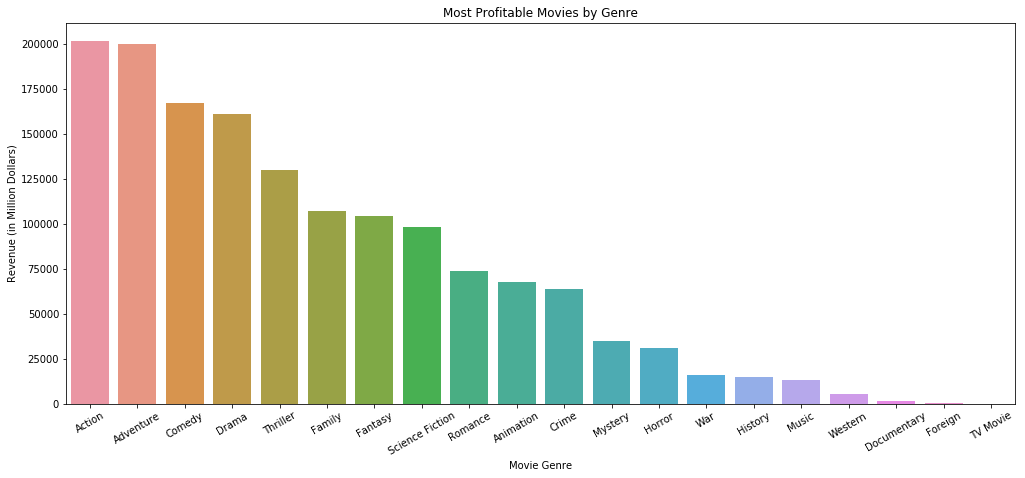

In [6]:
plt.figure(figsize=(17,7))
ax = sns.barplot(x=most_profitable_genre['genre'],y=most_profitable_genre['revenue'])
x=ax.set_xlabel("Movie Genre")
b=ax.set_ylabel("Revenue (in Million Dollars)")
c=ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=30)
d=ax.set_title("Most Profitable Movies by Genre")

### <font color='blue'>Brève analyse</font>  
Sans surprise nous pouvons voir que les genres qui rapportent le plus sont les films d'action et ceux d'aventure. 
On peut prendre pour exemple les films Marvel qui ont été un carton dans le box office.

## Populaire

Nous nous intéressons aux genres qui sont les plus populaires. Ils devraient correspondre à ceux qui fournissent le plus de revenu.

In [7]:
movies.drop(movies.index[35587], inplace=True)

genre_popularity = {}

for i,_ in movies.iterrows():
    for item in movies['genres'][i]:
        if 'name' in item and movies.iloc[i]['popularity'] is not np.nan:
            a = item['name']
            b = float(movies.iloc[i]['popularity'])
            if a in genre_popularity:
                genre_popularity[a]['total_popularity_points'] += b 
                genre_popularity[a]['total_popularity_counts'] += 1
            else:
                genre_popularity[a] = {}
                genre_popularity[a]['genre'] = a
                genre_popularity[a]['total_popularity_points'] = b
                genre_popularity[a]['total_popularity_counts'] = 0

most_popular_genre = pd.DataFrame(None,None,columns=['genre','average_popularity_points'])

for k,v in genre_popularity.items():
    most_popular_genre =  most_popular_genre.append({'genre':v['genre'],'average_popularity_points':v['total_popularity_points']/v['total_popularity_counts']},ignore_index=True)
    
most_popular_genre = most_popular_genre.sort_values(by='average_popularity_points',ascending=False)

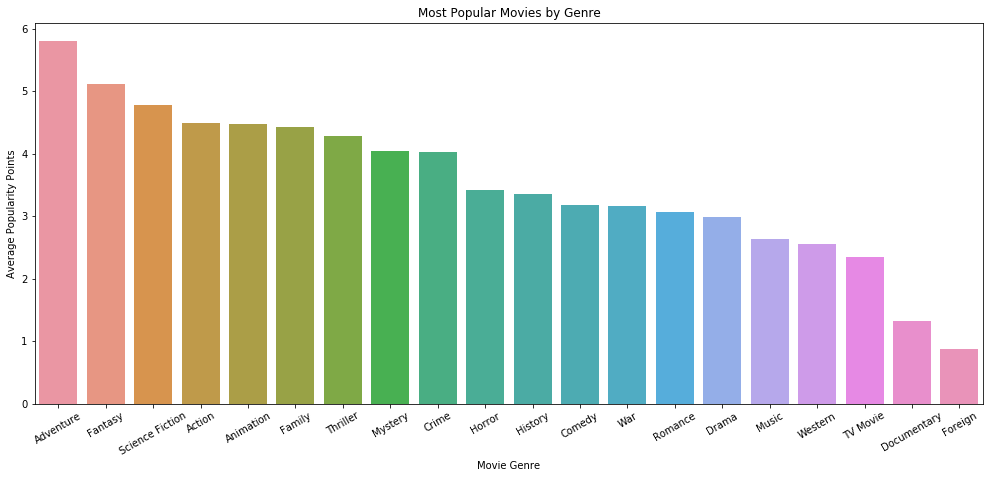

In [8]:
plt.figure(figsize=(17,7))
ax = sns.barplot(x=most_popular_genre['genre'],y=most_popular_genre['average_popularity_points'])
x=ax.set_xlabel("Movie Genre")
b=ax.set_ylabel("Average Popularity Points")
c=ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=30)
d=ax.set_title("Most Popular Movies by Genre")

### <font color='blue'>Brève analyse</font>  
Le genre Aventure est le plus populaire comme on pouvais s'y attendre. Cependant on peut voir que les films de Fantasy et de Science Fiction ont plus de succès que le genre Action.  
En effet selon notre avis Star Wars > Marvel.

## Acteurs

Nous avons choisi d'analyser la liste des acteurs. Par question de pertinence nous n'avons pris que les acteurs ayant jouer dans plus de 50 films.

Nous avons mis en place un fichier txt que nous avons par la suite convertis en csv nous même. Comme l'algorithme prend un peu (beaucoup) de temps. Nous avons laissé le code mais nous ne le lançons plus puisque nous avons déjà le ficher créer.

In [9]:
credit = pd.read_csv('the-movies-dataset/credits.csv')

In [10]:
"""cast = credit["cast"]

list_actor = []
list_actor_id = []
list_actor_appearance = []

longueur = len(cast)
for i in range(longueur): #liste de tout les acteurs
    list_cast = ast.literal_eval(cast[i])
    for j in list_cast:
        if j["id"] in list_actor_id:
            index = list_actor_id.index(j["id"])
            list_actor_appearance[index] += 1
        else:
            list_actor.append(j["name"])
            list_actor_id.append(j["id"])
            list_actor_appearance.append(1)

list_actor_final = []

longueur = len(list_actor)
"""

'cast = credit["cast"]\n\nlist_actor = []\nlist_actor_id = []\nlist_actor_appearance = []\n\nlongueur = len(cast)\nfor i in range(longueur): #liste de tout les acteurs\n    list_cast = ast.literal_eval(cast[i])\n    for j in list_cast:\n        if j["id"] in list_actor_id:\n            index = list_actor_id.index(j["id"])\n            list_actor_appearance[index] += 1\n        else:\n            list_actor.append(j["name"])\n            list_actor_id.append(j["id"])\n            list_actor_appearance.append(1)\n\nlist_actor_final = []\n\nlongueur = len(list_actor)\n'

In [11]:
"""fichier = open("list_actor.txt","w")

fichier.write('Acteur,id_Acteur,nb_films\n')

for i in range(longueur-1): #Garder les acteurs de + de x films
    if list_actor_appearance[i] >= 50: #Nombre de films minimum pour être dans la liste
        list_actor_final.append([list_actor[i],list_actor_id[i],list_actor_appearance[i]])
        fichier.write(str(list_actor[i]))
        fichier.write(',')
        fichier.write(str(list_actor_id[i]))
        fichier.write(',')
        fichier.write(str(list_actor_appearance[i]))
        fichier.write('\n')

fichier.close()"""

'fichier = open("list_actor.txt","w")\n\nfichier.write(\'Acteur,id_Acteur,nb_films\n\')\n\nfor i in range(longueur-1): #Garder les acteurs de + de x films\n    if list_actor_appearance[i] >= 50: #Nombre de films minimum pour être dans la liste\n        list_actor_final.append([list_actor[i],list_actor_id[i],list_actor_appearance[i]])\n        fichier.write(str(list_actor[i]))\n        fichier.write(\',\')\n        fichier.write(str(list_actor_id[i]))\n        fichier.write(\',\')\n        fichier.write(str(list_actor_appearance[i]))\n        fichier.write(\'\n\')\n\nfichier.close()'

In [12]:
actors = pd.read_csv('./list_actor.csv')
actors.sort_values(by=['nb_films'], ascending=False).head(10)

,actor,id,nb_films
337,'Bess Flowers',121323,241
319,'Christopher Lee',113,148
388,'John Wayne',4165,125
173,'Samuel L. Jackson',2231,123
413,'Michael Caine',3895,110
279,'Gérard Depardieu',16927,110
215,'Donald Sutherland',55636,109
377,'John Carradine',8516,109
143,'Jackie Chan',18897,108
29,'Frank Welker',15831,107


## Keywords

Nous allons analyser tous les mots-clé de chaque film afin de voir ceux qui reviennent le plus en fonction du genre.

Dans un premier temps nous enlevons toutes les valeurs qui contiennent une liste vide.  
Ensuite nous récupérons les genres. Puis nous créons un dataframe qui contient les mots clé et les genres. 

In [13]:
keywords = pd.read_csv('the-movies-dataset/keywords.csv')

In [14]:
keywords = keywords[keywords.astype(str)['keywords'] != '[]']
# keywords = keywords.set_index('id')
movie_genres = pd.concat([movies['id'],movies['genres']], axis = 1)
movie_genres = movie_genres[movie_genres.astype(str)['genres'] != "[]"]
movie_genres = movie_genres.set_index('id')

In [15]:
keywords.index = keywords.index.map(str)
movie_genres.index = movie_genres.index.map(str)
df_keywords_genre = pd.merge(keywords, movie_genres, left_index=True, right_index=True)

In [16]:
df_keywords_genre.index = df_keywords_genre.index.map(int)
df_keywords_genre.sort_index().head(10)

,id,keywords,genres
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name..."
5,949,"[{'id': 642, 'name': 'robbery'}, {'id': 703, '...","[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name..."
6,11860,"[{'id': 90, 'name': 'paris'}, {'id': 380, 'nam...","[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam..."
11,12110,"[{'id': 3633, 'name': 'dracula'}, {'id': 11931...","[{'id': 12, 'name': 'Adventure'}, {'id': 28, '..."
12,21032,"[{'id': 1994, 'name': 'wolf'}, {'id': 6411, 'n...","[{'id': 16, 'name': 'Animation'}, {'id': 10751..."
13,10858,"[{'id': 840, 'name': 'usa president'}, {'id': ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
14,1408,"[{'id': 911, 'name': 'exotic island'}, {'id': ...","[{'id': 18, 'name': 'Drama'}]"
15,524,"[{'id': 383, 'name': 'poker'}, {'id': 726, 'na...","[{'id': 9648, 'name': 'Mystery'}, {'id': 18, '..."
16,4584,"[{'id': 420, 'name': 'bowling'}, {'id': 818, '...","[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name..."


A l'aide de la liste de genres que nous avons trouvé avant nous récupérons les genres et les mots clés du dataset
movie_metadata et comptons :  
* l'occurence du mot clé dans toute le dataset
* l'occurence du mot clé par genre

In [17]:
genres = ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie']

list_keywords = []
list_appearance_genres = []
list_appearance = []

liste_nb_films = []
liste_nb_mots = []

liste_max = [0 for zero in range(20)]
liste_mot_max = ['' for zero in range(20)]

for i in range(len(df_keywords_genre)):#parcourir le dataframe -> len(df_keywords_genre)
    
    list_genres = [0 for zero in range(20)]
    
    line_genres = df_keywords_genre.iloc[i]['genres'] #convert la ligne en dict
    long_line_genres = len(line_genres)
    
    for j in range(20):#parcourir les genres
        
        for k in range(long_line_genres):#voir s'ils correspondent au film
            
            if str(line_genres[k]['name']) == genres[j]:#si oui, on passe à 1
                list_genres[j] = 1
    
    line_keywords = ast.literal_eval(df_keywords_genre.iloc[i]['keywords'])#convert la ligne en dict
    long_line_keywords = len(line_keywords)
    
    for j in range(long_line_keywords):#parcourir les keywords

        if str(line_keywords[j]['name']) in list_keywords:#voir s'il est déjà dans la lise des keywords
            ind = list_keywords.index(line_keywords[j]['name'])
            list_appearance[ind] += 1#incrementer son nombre d'appartion total
            
            for k in range(20):#incrementer son nombre d'apparition par genre
                list_appearance_genres[ind][k] += list_genres[k]
                
                if liste_max[k]<list_appearance_genres[ind][k]:#Mot le plus vu dans chaque genre
                    liste_max[k] = list_appearance_genres[ind][k]
                    liste_mot_max[k] = line_keywords[j]['name']
            
        else:
            list_keywords.append(str(line_keywords[j]['name']))
            list_appearance_genres.append(list(list_genres))
            list_appearance.append(1)    

In [18]:
df_keywords_appearance = pd.DataFrame(list(zip(list_keywords, list_appearance_genres, list_appearance)), columns =['Keyword', 'AppearancePerGenre', 'AppearanceTotal'])
df_keywords_appearance.sort_values(by=['AppearanceTotal'],ascending=False, inplace=True)
df_keywords_appearance = df_keywords_appearance[df_keywords_appearance['AppearanceTotal'] > 1]
df_keywords_appearance.head(10)

,Keyword,AppearancePerGenre,AppearanceTotal
293,woman director,"[58, 443, 109, 120, 82, 236, 636, 248, 172, 28...",1279
17,independent film,"[44, 298, 67, 113, 60, 144, 436, 179, 106, 196...",853
51,murder,"[27, 197, 43, 77, 43, 97, 241, 116, 73, 117, 7...",539
422,based on novel,"[11, 115, 20, 36, 24, 61, 184, 61, 43, 78, 40,...",353
443,musical,"[12, 119, 23, 32, 20, 60, 151, 48, 39, 67, 42,...",319
76,sex,"[10, 118, 21, 30, 25, 49, 143, 57, 43, 81, 63,...",315
221,violence,"[13, 103, 24, 30, 31, 43, 119, 61, 29, 62, 40,...",277
470,nudity,"[13, 96, 25, 28, 22, 49, 148, 48, 28, 62, 41, ...",277
220,revenge,"[14, 87, 19, 45, 21, 47, 143, 64, 41, 55, 27, ...",271
52,suspense,"[11, 102, 25, 33, 22, 51, 132, 54, 46, 62, 27,...",263


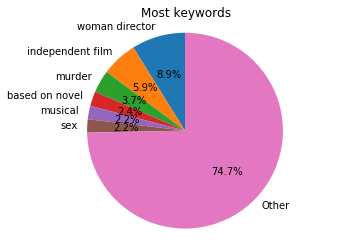

In [19]:
df_keywords_appearance_head = df_keywords_appearance.head(100)
sum_mots = df_keywords_appearance_head['AppearanceTotal'].sum()

#pour les 100 mots les plus utilisés on regarde la proportion

list_occur_mots = []
liste_mots = []

for i in range(6):
    list_occur_mots.append(df_keywords_appearance_head.iloc[i]['AppearanceTotal'])
    sum_mots -= df_keywords_appearance_head.iloc[i]['AppearanceTotal']
    liste_mots.append(df_keywords_appearance_head.iloc[i]['Keyword'])

list_occur_mots.append(sum_mots)
liste_mots.append('Other')

labels = liste_mots
sizes = list_occur_mots

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, startangle=90)
ax1.axis('equal')

plt.title('Most keywords')
plt.savefig('keywords.jpeg')

plt.show()

In [20]:
matrix_max_per_genre = [[0 for zero in range(10)] for i in range(20)]#les 10 mots les plus utilisés par genre
matrix_keywords = [['' for zero in range(10)] for i in range(20)]

for i in range(10):
    
    for j in range(100):#on parcourt le df de 100 lignes
        
        for k in range(20):#on parcourt par genre
            
            if df_keywords_appearance_head.iloc[j]['AppearancePerGenre'][k] > matrix_max_per_genre[k][i]:#on teste si c'est le max
                
                    if not df_keywords_appearance_head.iloc[j]['Keyword'] in matrix_keywords[k]:#on teste s'il est déjà dans la liste
                    
                        matrix_max_per_genre[k][i] = df_keywords_appearance_head.iloc[j]['AppearancePerGenre'][k]
                        matrix_keywords[k][i] = df_keywords_appearance_head.iloc[j]['Keyword']

In [21]:
for i in range(20):
    print(genres[i])
    print(pd.DataFrame(list(zip(matrix_keywords[i], matrix_max_per_genre[i])), columns=['Keyword','Nombre']))
    print("___________________________")

Animation
                Keyword  Nombre
0        woman director      58
1      independent film      44
2                murder      27
3               revenge      14
4              teenager      14
5              violence      13
6                nudity      13
7                 sport      13
8  duringcreditsstinger      13
9               musical      12
___________________________
Comedy
            Keyword  Nombre
0    woman director     443
1  independent film     298
2            murder     197
3           musical     119
4               sex     118
5    based on novel     115
6          violence     103
7          suspense     102
8            nudity      96
9              love      92
___________________________
Family
            Keyword  Nombre
0    woman director     109
1  independent film      67
2            murder      43
3            nudity      25
4          suspense      25
5          violence      24
6           musical      23
7               sex      21
8     fe

In [22]:
df_occur_mots_par_genres = pd.DataFrame(list(zip(genres, liste_mot_max, liste_max)), columns =['Genre','Keyword','Nombre'])
df_occur_mots_par_genres.sort_values(by=['Nombre'],ascending=False, inplace=True)
df_occur_mots_par_genres

,Genre,Keyword,Nombre
6,Drama,woman director,636
1,Comedy,woman director,443
9,Thriller,woman director,288
7,Action,woman director,248
5,Romance,woman director,236
10,Horror,woman director,172
8,Crime,woman director,172
3,Adventure,woman director,120
2,Family,woman director,109
12,Science Fiction,woman director,108


### <font color='blue'>Brève analyse</font>   
Le mot qui apparait le plus de fois est "woman director".  
Il parait étrange que quand c'est une femme qui produit le film ce soit mentionné dans les mots-clés alors que quand il s'agit d'un homme ce n'est pas mentionné car apparement ca semble "evident". 

## Films par an et par pays

Nous gardons les colonnes qui nous intéresse pour l'analyse des films par an. Nous supprimons les lignes superflues (notamment deux lignes qui ont pour release date 1, 12 and 22)

In [3]:
movies = pd.read_csv('the-movies-dataset/movies_metadata.csv');

/Users/romane/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
movies.drop(columns=['adult','belongs_to_collection','genres','homepage','id','imdb_id','original_language','original_title','overview','spoken_languages','status','tagline','video','vote_average','vote_count','popularity','poster_path','production_companies'], inplace=True)
movies.drop(columns=['budget','runtime','revenue'], inplace=True)
movies.sort_values(by='release_date', inplace=True)
movies = movies[movies.astype(str)['release_date'] != '1']
movies = movies[movies.astype(str)['release_date'] != '12']
movies = movies[movies.astype(str)['release_date'] != '22']
movies.dropna(subset=['release_date'],inplace=True)

In [25]:
liste_pays = []

for i in range(len(movies)):
    if ast.literal_eval(movies.iloc[i]['production_countries']) != []:
        liste_pays.append(ast.literal_eval(movies.iloc[i]['production_countries'])[0]['name']) #convert la ligne en dict
    else:
        liste_pays.append('Unknown')

movies['pays'] = liste_pays
movies.drop(columns=['production_countries'], inplace=True)


movies

,release_date,title,pays
34940,1874-12-09,Passage of Venus,France
34937,1878-06-14,Sallie Gardner at a Gallop,United States of America
41602,1883-11-19,Buffalo Running,United States of America
34933,1887-08-18,Man Walking Around a Corner,United States of America
34934,1888-01-01,Accordion Player,United Kingdom
34938,1888-10-15,Traffic Crossing Leeds Bridge,United Kingdom
34939,1890-01-01,London's Trafalgar Square,United Kingdom
41194,1890-03-09,Mosquinha,Unknown
34936,1890-11-21,"Monkeyshines, No. 2",United States of America
39954,1890-11-21,"Monkeyshines, No. 3",United States of America


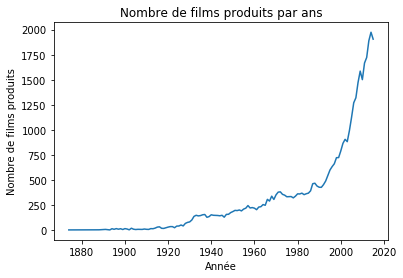

In [26]:
df_dates = movies['release_date'].groupby([pd.to_datetime(movies['release_date']).dt.year]).agg({'count'})
# La base de données n'étant pas mis à jour nous enlevons les films de 2016 à 2020.
df_dates = df_dates[df_dates.index != 2016]
df_dates = df_dates[df_dates.index != 2017]
df_dates = df_dates[df_dates.index != 2018]
df_dates = df_dates[df_dates.index != 2019]
df_dates = df_dates[df_dates.index != 2020]
plt.plot(df_dates.index, df_dates['count'])
plt.xlabel('Année')
plt.ylabel('Nombre de films produits')
plt.title('Nombre de films produits par ans')
plt.show()

## Régression linéaire

Nous allons faire de la régression linéaire pour voir si l'algorithme pourrait prédire la note du film en fonction de genres et du nombre de notes.


Nous avons donc deux bases de données qui contiennent la note des films.  
- TMDB
- IMDB

Nous alors applique une régression linéaire sur les deux bases de donnés.

In [27]:
ratings = pd.read_csv('./the-movies-dataset/ratings.csv')
notes = ratings['movieId'].groupby([ratings['movieId'], ratings['rating']]).agg({'count'})

In [28]:
rate = []
i=0
while i < len(notes):
    movie_id = notes.index[i][0]
    total = 0
    moyenne = 0
    while i < len(notes) and movie_id == notes.index[i][0]:
        total += notes.iloc[i][0]
        moyenne += notes.iloc[i][0]*notes.iloc[i].name[1]
        i += 1
    rate.append((movie_id, int(moyenne*100/total)/100, total))
average = pd.DataFrame(rate, columns=['movieId', 'rating', 'vote'])

In [29]:
movies = pd.read_csv('./the-movies-dataset/movies_metadata.csv')

movies.drop(columns=['adult', 'belongs_to_collection', 'homepage', 'imdb_id', 'original_language', 'original_title',\
                     'overview', 'poster_path', 'production_companies', 'production_countries', 'release_date',\
                     'spoken_languages', 'status', 'tagline', 'video'], inplace=True)


movies.dropna(inplace = True)

movies['budget'] = movies['budget'].astype('int32')
movies = movies[movies['budget'] > 100]

movies['revenue'] = movies['revenue'].astype('int32')
movies = movies[movies['revenue'] > 100]

movies = movies[movies['revenue'] != np.min(movies['revenue'])]

adult                    45466
belongs_to_collection     4494
budget                   45466
genres                   45466
homepage                  7782
id                       45466
imdb_id                  45449
original_language        45455
original_title           45466
overview                 44512
popularity               45461
poster_path              45080
production_companies     45463
production_countries     45463
release_date             45379
revenue                  45460
runtime                  45203
spoken_languages         45460
status                   45379
tagline                  20412
title                    45460
video                    45460
vote_average             45460
vote_count               45460
dtype: int64


/Users/romane/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [30]:
links = pd.read_csv('./the-movies-dataset/links.csv')
links.drop(columns=['imdbId'], inplace=True)
links.dropna(inplace=True)
links.tmdbId = links.tmdbId.astype('int64')

In [31]:
movies_ratings = movies.join(links, lsuffix='id', rsuffix='tmbdId')

movies_ratings.drop(columns=['id', 'tmdbId'], inplace=True)
movies_ratings['movieId'].dropna(inplace=True)

movies_ratings = movies_ratings.join(average, lsuffix='movieId', rsuffix='movieID')
movies_ratings.drop(columns=['movieIdmovieId', 'movieIdmovieID'], inplace=True)
movies_ratings.rename(columns={'vote_average':'avg_tmdb', 'vote_count':'count_tmdb', 'rating':'avg_imdb', 'vote':'count_imdb'}, inplace=True)

movies_ratings['avg_tmdb'] = movies_ratings['avg_tmdb'] / 2

movies_ratings.dropna(inplace=True)

budget        5312
genres        5312
popularity    5312
revenue       5312
runtime       5312
title         5312
avg_tmdb      5312
count_tmdb    5312
avg_imdb      5312
count_imdb    5312
dtype: int64

In [32]:
# One hot encode genres
list_genres_par_films = []
for genres in movies_ratings['genres']:
    genres_list = ast.literal_eval(genres)
    k = [i['name'] for i in genres_list]
    list_genres_par_films.append(k)
movies_ratings['genres'] = list_genres_par_films

one_hot_encode_genres = movies_ratings['genres'].str.join('|').str.get_dummies()
movies_ratings = pd.concat([movies_ratings, one_hot_encode_genres], axis=1)
movies_ratings.drop(columns='genres', inplace=True)

In [33]:
def model(feature, output): 
    model_genres = LogisticRegression()
    X = feature
    Y = output

    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3)
    model_genres.fit(X_train,Y_train)
    model_genres.predict(X_train)

    print(model_genres.score(X_train, Y_train),'regression train.')
    print(model_genres.score(X_test,Y_test),'regression test.\n')

## TMDB

Nous essayons sur plusieurs features de faire de la régression sur la note moyenne. Nous prenons tout le temps en compte le nombre de votes.  
Nous testons sur: 
- Les genres
- Le profit d'un film

In [34]:
# Nous enlevons tous les films qui ont moins de 10 notes
movies_tmdb = movies_ratings[(movies_ratings['count_tmdb'] > 100) & (movies_ratings['avg_tmdb'] > 0.5)]

In [42]:
genres = movies_tmdb[['count_tmdb','Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie']]
profit = movies_tmdb[['count_tmdb','budget', 'revenue']]
popularity = movies_tmdb[['count_tmdb','runtime', 'popularity']]
all_ = movies_tmdb[['count_tmdb','Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie' ,'budget', 'revenue', 'runtime', 'popularity']]

avg_tmdb = movies_tmdb['avg_tmdb'].astype('int')

print('Genres')
model(genres, avg_tmdb)

print('Profit')
model(profit, avg_tmdb)

print('Popularity')
model(popularity, avg_tmdb)

print('Toutes les colonnes.')
model(all_, avg_tmdb)


Genres
0.7300567107750473 regression train.
0.7142857142857143 regression test.

Profit
0.6570888468809074 regression train.
0.6419753086419753 regression test.

Popularity
0.6926275992438563 regression train.
0.6710758377425045 regression test.

Toutes les colonnes.
0.6567107750472589 regression train.
0.6437389770723104 regression test.



/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

### <font color='blue'>Brève analyse</font>  

Il semblerait que la meilleure feature soit quand nous prenons en compte les genres.  
Nous allons maintenant montrer que le nombre de vote pris en compte joue grandement sur la note obtenue.

Pour  0  votes comptés.
0.692328398384926 regression train.
0.6886377903327056 regression test.

Pour  10  votes comptés.
0.7001414427157001 regression train.
0.7097625329815304 regression test.



/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

Pour  20  votes comptés.
0.7162763118885266 regression train.
0.6894882434301521 regression test.

Pour  30  votes comptés.
0.7186534898085237 regression train.
0.696685878962536 regression test.



/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

Pour  40  votes comptés.
0.7160178685386088 regression train.
0.7075892857142857 regression test.

Pour  50  votes comptés.
0.7116524028966426 regression train.
0.718342287029931 regression test.



/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pour  60  votes comptés.
0.7166101694915255 regression train.
0.7201581027667984 regression test.

Pour  70  votes comptés.
0.7201115371209481 regression train.
0.7040650406504065 regression test.



/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

Pour  80  votes comptés.
0.7255113024757804 regression train.
0.7121338912133891 regression test.

Pour  90  votes comptés.
0.7247605011053795 regression train.
0.7139175257731959 regression test.



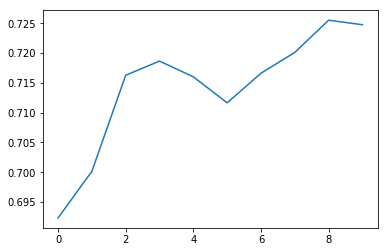

In [36]:
nb_votes_min = np.arange(0, 100, 10)
scores = []

for i in nb_votes_min:
    movies_tmdb_tmp = movies_ratings[(movies_ratings['count_tmdb'] > i) & (movies_ratings['avg_tmdb'] > 0.5)]

    model_genres = LogisticRegression()
    X = movies_tmdb_tmp[['count_tmdb','Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie']]
    Y = movies_tmdb_tmp['avg_tmdb'].astype('int')


    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3)
    model_genres.fit(X_train,Y_train)
    model_genres.predict(X_train)
    scores.append(model_genres.score(X_train, Y_train))
    
    print('Pour ', i, ' votes comptés.')
    print(model_genres.score(X_train, Y_train),'regression train.')
    print(model_genres.score(X_test,Y_test),'regression test.\n')

plt.plot(scores)

### <font color='blue'>Brève analyse</font>  

Plus nous réduisons le nombre de vote minimal, plus notre accuracy est élevée. Voyons ce qu'il en est chez IMDB.

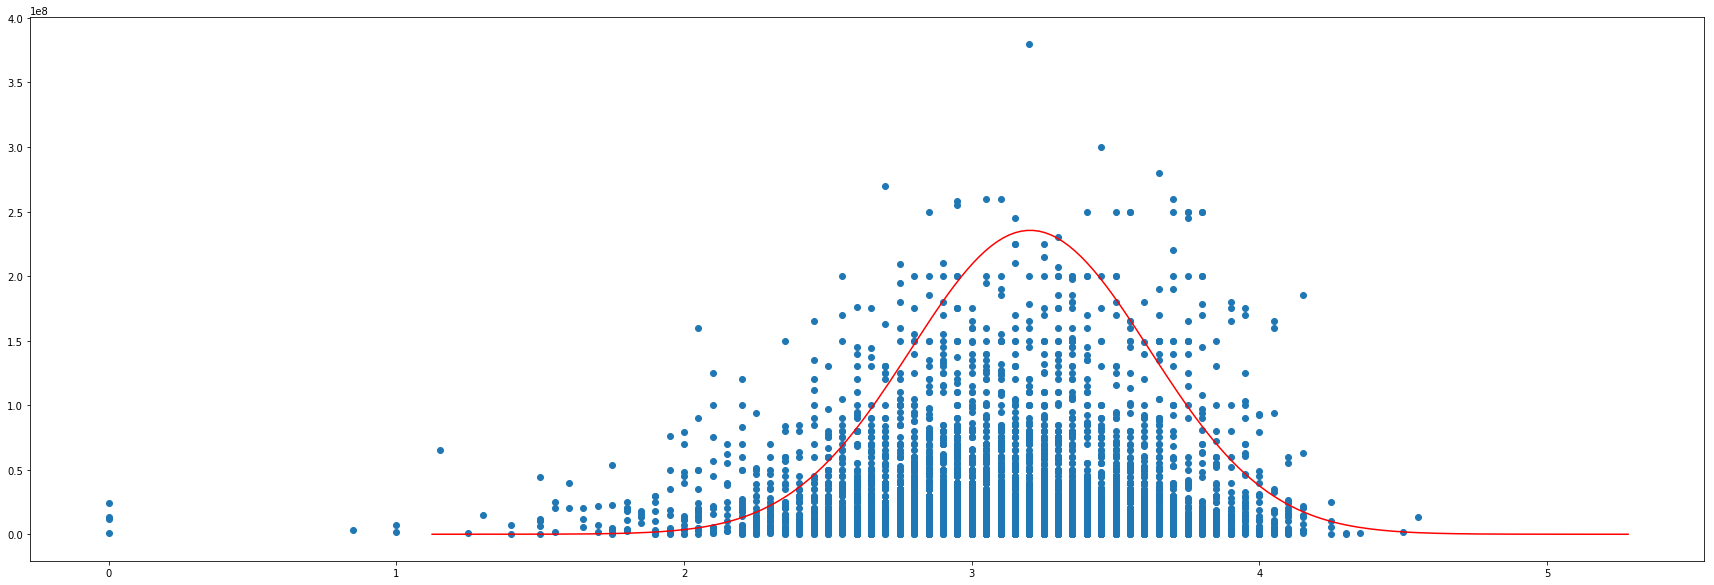

In [37]:
plt.figure(figsize=(30,10))

mu = np.mean(movies_tmdb['avg_tmdb'])
sigma = np.std(movies_tmdb['avg_tmdb'])

x = np.linspace(mu - 5*sigma, mu + 5*sigma, 200)

plt.plot(x, 2*np.mean(movies_tmdb['revenue'])*stats.norm.pdf(x, mu, sigma), 'r')

plt.scatter(movies_ratings['avg_tmdb'].astype('float'), movies_ratings['budget'])
plt.xlabel("Revenue")
plt.ylabel("Average ratings TMDB")
plt.show()

## IMDB

In [38]:
# Nous enlevons tous les films qui ont moins de 10 notes
movies_imdb = movies_ratings[(movies_ratings['count_imdb'] > 100) & (movies_ratings['avg_imdb'] > 0.5)]

In [47]:
genres = movies_imdb[['count_imdb','Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie']]
profit = movies_imdb[['count_imdb','budget', 'revenue']]
popularity = movies_imdb[['count_imdb','runtime', 'popularity']]
all_ = movies_imdb[['count_imdb','Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie' ,'budget', 'revenue', 'runtime', 'popularity']]

avg_imdb = movies_imdb['avg_imdb'].astype('int')

print('Genres')
model(genres, avg_imdb)

print('Profit')
model(profit, avg_imdb)

print('Popularity')
model(popularity, avg_imdb)

print('Toutes les colonnes.')
model(all_, avg_imdb)


Genres
0.6918090748379493 regression train.
0.7005494505494505 regression test.

Profit
0.6823806717737183 regression train.
0.6456043956043956 regression test.

Popularity
0.6935769004124926 regression train.
0.6991758241758241 regression test.

Toutes les colonnes.
0.6812021213906895 regression train.
0.7225274725274725 regression test.



/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

Pour  0  votes comptés.
0.7358142962417097 regression train.
0.7010309278350515 regression test.



/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

Pour  10  votes comptés.
0.7214443625644805 regression train.
0.7225085910652921 regression test.

Pour  20  votes comptés.
0.7254974207811349 regression train.
0.7268041237113402 regression test.

Pour  30  votes comptés.
0.7273397199705232 regression train.
0.7173539518900344 regression test.

Pour  40  votes comptés.
0.717391304347826 regression train.
0.743127147766323 regression test.

Pour  50  votes comptés.


/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

0.7269712601326456 regression train.
0.7190721649484536 regression test.

Pour  60  votes comptés.
0.7144436256448047 regression train.
0.7328178694158075 regression test.

Pour  70  votes comptés.
0.7369196757553427 regression train.
0.7053264604810997 regression test.

Pour  80  votes comptés.
0.7210759027266028 regression train.
0.7199312714776632 regression test.

Pour  90  votes comptés.
0.7210759027266028 regression train.
0.7147766323024055 regression test.



/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


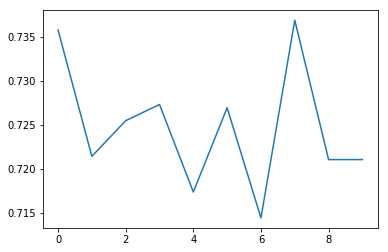

In [40]:
nb_votes_min = np.arange(0, 100, 10)
scores = []

for i in nb_votes_min:
    movies_tmdb_tmp_tmp = movies_ratings[(movies_ratings['count_tmdb'] > i) & (movies_ratings['avg_tmdb'] > 0.5)]

    model_genres = LogisticRegression()
    X = movies_tmdb_tmp[['count_tmdb','Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 'Documentary', 'Western', 'TV Movie']]
    Y = movies_tmdb_tmp['avg_tmdb'].astype('int')


    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3)
    model_genres.fit(X_train,Y_train)
    model_genres.predict(X_train)
    scores.append(model_genres.score(X_train, Y_train))
    
    print('Pour ', i, ' votes comptés.')
    print(model_genres.score(X_train, Y_train),'regression train.')
    print(model_genres.score(X_test,Y_test),'regression test.\n')

plt.plot(scores)

### <font color='blue'>Brève analyse</font>  

On peut voir que en fonction du nombre de votes pris en compte l'accuracy varie mais cela semble tellement minime (de l'ordre 0.01) que le nombre de vote minimal n'influe pas sur la prédiction. Pas comme son comparse TMDB.

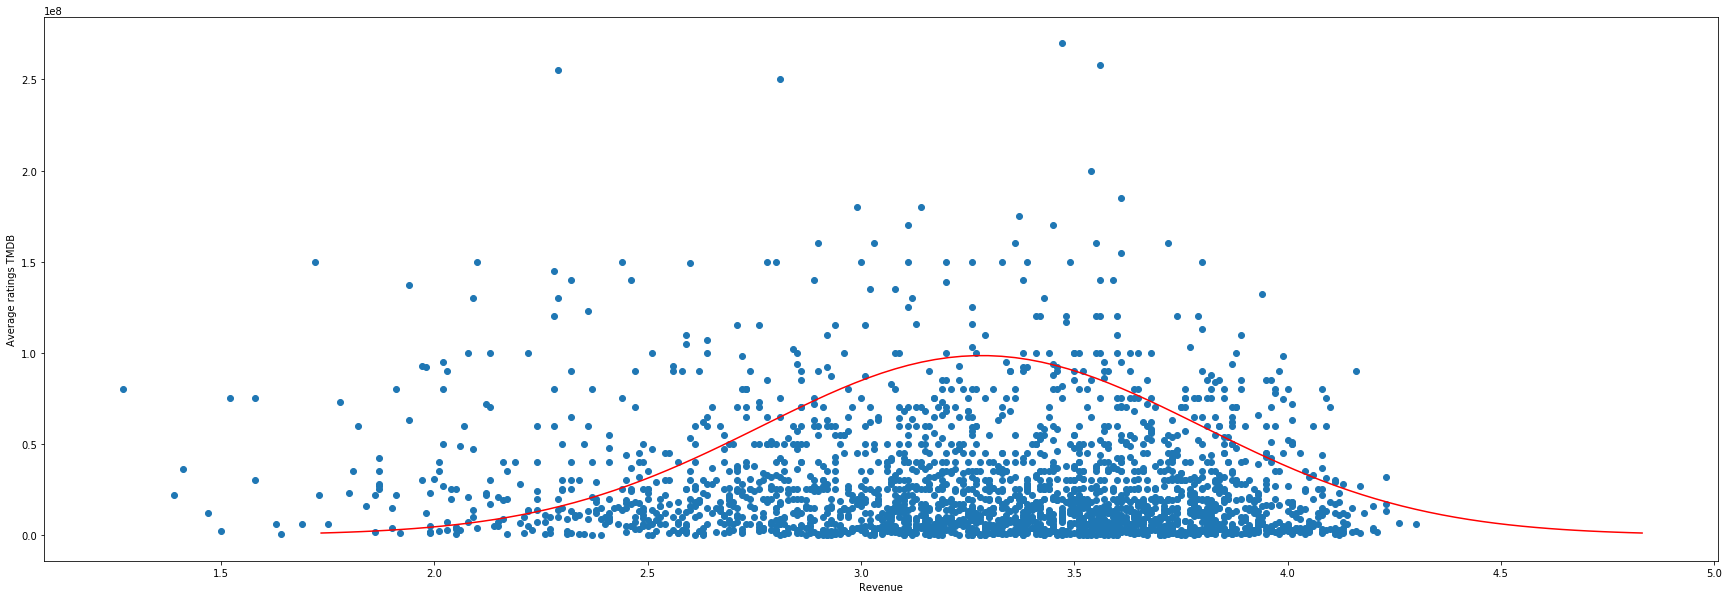

In [41]:
plt.figure(figsize=(30,10))

mu = np.mean(movies_imdb['avg_imdb'])
sigma = np.std(movies_imdb['avg_imdb'])

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)

plt.plot(x, np.std(movies_imdb['revenue'])*stats.norm.pdf(x, mu, sigma), 'r')


plt.scatter(movies_imdb['avg_imdb'].astype('float'), movies_imdb['budget'])

plt.xlabel("Revenue")
plt.ylabel("Average ratings IMDB")
plt.show()